In [1]:
%load_ext autoreload

In [2]:
#always reload modules so that as you change code, it gets loaded
%autoreload 2
#%aimport rl # make sure you call once: pip install -e . 

from collections.abc import Iterator, Mapping
from typing import Any

import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

from rl.dynamic_programming_np import value_iteration

> Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. 
> To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!} e^{- \lambda}$ ,where is the expected number. 
> Suppose $\lambda$ is $3$ and $4$ for rental requests at the first and second locations and $3$ and $2$ for returns. To simplify the problem slightly, we assume that there can be no more than $20$ cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. 
> We take the discount rate to be $\gamma=0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

### Solution
> For two locations, $A$ and $B$, let us represent the state at time step (day) $t$ by
> $$
     s^{t} = (n_A^t, n_B^t),
> $$
> where $n_A^t$ and $n_B^t$ are the number of available cars in $A$ and $B$ at start of the day.
> Denoting the renting and returning cars at tme step $t$ as $R_i^t$ and $r_i^t$ for $i \in \{A, B\}$, these are Possion random variables such that
> $$
    P(R_i^t) = \frac{\lambda_{1i}^{R_i^t} e^{-\lambda_{1i}}}{R_i^t!}, \qquad P(r_i^t) = \frac{\lambda_{2i}^{r_i^t} e^{-\lambda_{2i}}}{r_i^t!}.
> $$
> However, it is said the maximum capcity of each station is $20$ cars, and the additional cars are returned to the nationwide company. So, we assume the distinutions are not Poission but a cut-Poisson as follows: given $n_i$ cars available at station $i$
> $$
   P(R_i^t |n_i^t) = \left\{ \begin{matrix}
   \frac{\lambda_{1i}^{R_i^t} e^{-\lambda_{1i}}}{R_i^t!}, & R_i^t < n_i^t\\
   1 - \sum_{i=0}^{n_i^t-1} \frac{\lambda_{1i}^{i^t} e^{-\lambda_{1i}}}{i^t!} & \text{otherwise}\\
   \end{matrix}
   \right.
> $$
> Then, the joint probability distibution of $R_i^t$ and $r_i^t$ is writen
> $$
    P(R_i^t, r_i^t | n_i^t) = P(R_i^t | n_i^t) P(r_i^t |R_i^t, n_i^t),
> $$
> such that
> $$
P(r_i^t |R_i^t, n_i^t) = \left\{ \begin{matrix}
   \frac{\lambda_{2i}^{r_i^t} e^{-\lambda_{2i}}}{r_i^t!}, & r_i^t < 20 - n_i^t + R_i^t\\
   1 - \sum_{i=0}^{19 - n_i^t+ R_i^t} \frac{\lambda_{2i}^{i^t} e^{-\lambda_{2i}}}{i^t!} & \text{otherwise}\\
   \end{matrix}
   \right..
> $$
> Notice that the reward value is deterministice and equal to $r^t = 10R_i^t - 2 m^t$ when $m^t$ is the number of cars that transfered between two stations. This is resulted since the profit of each rented car is 10 dollars and the transfer of each car costs 2 dollars.
> Putting together, the dynamics write as
> $$
    P(s^{t+1}, r^t | s^t, a = m^{t}) = P(R_A^t | n_A^t) P(r_A^t |R_A^t, n_A^t) P(R_B^t | n_B^t) P(r_B^t |R_B^t, n_B^t) \mathcal{1}_{0 \le n_A^t - R_A^t + r_A^t + m^{t} \le 20} \mathcal{1}_{0 \le n_B^t - R_B^t + r_B^t - m^{t} \le 20}
> $$
> for $s^t = (n_A^t, n_B^t)$, $r^t = 10R_i^t - 2 m^t$, $s^{t+1} = (n_A^t - R_A^t + r_A^t + m^{t}, n_B^t - R_B^t + r_B^t - m^{t})$, and $\mathcal{1}_{condition}$ is the indicator function.
> Similarly, the equiprobable policy is written
> $$
\pi(a = m^{t} | s^t ) = \frac{1}{2m^{t}+1}, \qquad m^{t} \in \{-5, -4, \dots, 5\}.
> $$


In [3]:
# Simple Poisson cut
def Poisson_cut(k, lamb, n_max):
    """
    The Poission distribution that cuts as 'n_max'
    Probability of p(n_max) = 1 - F(n_max), where F(n_max)
    is the CDF of the Poission distribution. This
    way, the pdf is normalised too.
    """
    if k < n_max and k > -1:
        return poisson.pmf(k, lamb)
    elif k == n_max:
        return 1 - poisson.cdf(n_max-1, lamb)
    else:
        return 0.0
    
# Vectorised Poisson cut
def create_Poisson_cut(lamb):
    def Poisson_cut_np(k, n_max):  
        """
        Vectorised version of Poisson_cut.
        """      
        return np.where((k < -1) & (k > n_max),
                        0.0,                        
                        np.where(k < n_max,
                                 poisson.pmf(k, lamb),
                                 1 - poisson.cdf(n_max-1, lamb)
                                )
                        )
    return Poisson_cut_np
# Vectorised dynamic distribution
def create_dist(lamb_1A = 3, lamb_2A = 3,
                lamb_1B = 4, lamb_2B = 2):
    Rent_A_p = create_Poisson_cut(lamb_1A)
    Rent_B_p = create_Poisson_cut(lamb_1B)
    Return_A_p = create_Poisson_cut(lamb_2A)
    Return_B_p = create_Poisson_cut(lamb_2B)
    def dist(mat, n_A:int, n_B:int,
             n_A_max:int, n_B_max:int):
        """
        P(R_A| n_A)P(r_A|R_A, n_A) x P(R_B| n_B)P(r_B|R_B, n_B)
        
        For R_A in {0, ... n_A}, r_A in {0, ..., n_A - R_A},
        R_B in {0, ... n_B}, and r_B in {0, ..., n_B - R_B},
        all four distributions are normalised.

        Parameters:
        -----------
        mat: ndarray
            R_A , r_A, R_B , r_B = mat
        
        n_A: int
            Current number of cars in station A.
        
        n_B: int
            Current number of cars in station B.
        
        n_A_max: int
            Station A maximumcapacity.

        n_B_max: int
            Station B maximumcapacity.

        Returns:
        --------
        ndarray
            Probability of the Renting and returning of 
            both stations
        """
        # Unpack the values
        R_A , r_A, R_B , r_B = mat[:,0], mat[:,1], mat[:,2], mat[:,3]
        return (Rent_A_p(R_A, n_A)*Return_A_p(r_A, n_A_max-(n_A-R_A))
               *Rent_B_p(R_B, n_B)*Return_B_p(r_B, n_B_max-(n_B-R_B))
               # Indicator functions
               *np.where((n_A - R_A + r_A >= 0) & (n_A - R_A + r_A <= n_A_max), 1.0, 0.0)
               *np.where((n_B - R_B + r_B >= 0) & (n_B - R_B + r_B <= n_B_max), 1.0, 0.0)
        )
    return dist

In [4]:
class Moving_Cars_Policy(dict):
    """
    States:
    -------
    cars numbers at the end of the day
        (n_A,  n_B) in {(0,0), (0,1), ..., (n_A_max, n_B_max)}

    Actions:
    --------
    moving carrs
        Positive values: Cars move from station A to B.
        Negative values: Cars move from station B to A.
        m must be at most equal to avaible cars which are
        -n_B-m_max and n_A+m_max.
        m = {-n_B-m_max, -n_B-m_max-1, ..., n_A+m_max}          

    Rewards:
    --------
    profit
        r = 10 R_A + 10 R_B - 2 |m|
    """
    def __init__(self, n_A_max: int, n_B_max:int, m_max:int) -> None:

        states = ((n_A, n_B) for n_A in range(n_A_max+1)# possible n_As
                             for n_B in range(n_B_max+1)# possible n_Bs
                             )
        # Initial policy assumes equal probability for all possible actions.
        # So, for all values of ms for a given (n_A, n_B), it assign equal
        # probability 1/(n_A+n_B).
        # To cut the maximum m at n_max, here we used min function.
        super().__init__({
            (n_A, n_B) : {m:1/(min(n_A, m_max)+min(n_B, m_max)+1)# equal probability
                          for m in range(-min(n_B, m_max),  min(n_A, m_max)+1)# cars avalable in stations
                         }
                            for (n_A, n_B) in states
                        })        

class Single_state_Dynamics(dict):
    
    def __init__(self, states_value,
                 n_A:int, n_B:int,
                 m:int, n_A_max: int, n_B_max:int, m_max:int,
                 lamb_1A:float = 3., lamb_2A:float = 3.,
                 lamb_1B:float = 4., lamb_2B:float = 2.) -> None:
        self.n_A = n_A
        self.n_B = n_B
        self.m = m
        self.n_A_max = n_A_max
        self.n_B_max = n_B_max
        self.m_max = m_max
        dist = create_dist(lamb_1A, lamb_2A, lamb_1B, lamb_2B)

        # All possible combinations of renting and retuned
        # cars based on the given current states (n_A, n_B),
        # transfred cars, m, and maximum capacities (max_n_A, max_n_B)

        # First, corrected the total number of  cars( Since m car leaves the station A 
        # and enter the station B, the values are corrected first)
        n_A = n_A - m
        n_B = n_B + m
        # After renting R_A (R_B) cars in station A (B), there are only at most
        # n_A_max-(n_A - R_A) (n_B_max-(n_B - R_B)) parking space for
        # returing cars
        mat = np.fromiter(((R_A , r_A, R_B , r_B)
                    for R_A in range(n_A + 1)# possible R_As
                    for r_A in range(n_A_max-(n_A - R_A) + 1)# possible r_As
                    for R_B in range(n_B + 1)# possible R_Bs
                    for r_B in range(n_B_max-(n_B - R_B) + 1)# possible r_Bs
                    ) , dtype = np.dtype((int, 4)))
        # Unpack the values for vectorised calculation
        R_A , r_A, R_B , r_B = mat[:,0], mat[:,1], mat[:,2], mat[:,3]
        # Calculate the next stats and rewards
        mat2 = np.array([n_A - R_A + r_A, n_B - R_B + r_B, 10*R_A + 10*R_B -2*abs(m)]).T
        # Calculate the probabilites of each combinations
        # Note: the range of R_A, r_A, R_B, and r_B satisfies
        #       the normalisation condition, given the n_A, n_B
        probs = dist(mat, n_A, n_B, n_A_max, n_B_max)
        #
        keys_values = {}
        # aggregate the probabilites of all cases with the same next state
        # and rewards
        for (next_n_A, next_n_B, reward), prob_1 in zip(mat2, probs):             
            k = ((int(next_n_A), int(next_n_B)), int(reward))            
            keys_values[k] = keys_values.get(k, 0.0) + prob_1

        #states = np.array([k[0] for k in keys_values], dtype='int, int') 
        #                     for s in states])        
        indices = np.array([states_value['states'][tuple(k[0])] for k in keys_values])
        rewards = np.array([k[1] for k in keys_values])
        probs = np.array([v for v in keys_values.values()])

        super().__init__({
            #"states": states,
            "indices": indices,
            "rewards": rewards,
            "probs": probs,
        })
            
class Stations_Dynamics(Mapping):
    """
    States:
    -------
    cars numbers at the end of the day
        (n_A,  n_B) in {(0,0), (0,1), ..., (n_A_max, n_B_max)}

    Actions:
    --------
    moving carrs
        Positive values: Cars move from station A to B.
        Negative values: Cars move from station B to A.
        m must be at most equal to avaible cars which are
        -n_B-m_max and n_A+m_max.
        m = {-n_B-m_max, -n_B-m_max-1, ..., n_A+m_max}          

    Rewards:
    --------
    profit
        r = 10 R_A + 10 R_B - 2 |m|
    """
    def __init__(self, states_value, n_A_max: int, n_B_max:int, m_max:int) -> None:
        
        states = ((n_A, n_B) for n_A in range(n_A_max+1)# possible n_As
                             for n_B in range(n_B_max+1)# possible n_Bs
                             )
        
        self.__states_actions__ = {
            ((n_A, n_B), m): Single_state_Dynamics(states_value, n_A, n_B, m, n_A_max, n_B_max, m_max) 
            for (n_A, n_B) in states
            for m in range(-min(n_B, m_max),  min(n_A, m_max)+1)# cars avalable in stations
        }
        

    def __contains__(self, key: object) -> bool:
        return key in self.__states_actions__.keys()

    def __iter__(self) -> Iterator:
        return iter(self.__states_actions__.keys())

    def __len__(self) -> int:
        return len(self.__states_actions__)

    def __getitem__(self, key: Any) -> Any:        
        return self.__states_actions__[key]    
        
    def __repr__(self) -> str:
        if len(self.__states_actions__) > 100:
            return "Too long"
        return "{\n" + "".join([ f"({state},{action}):{self[(state,action)]}\n"
            for state, action in self.__states_actions__]) + "\n}"

In [5]:
# Problem's parameters
n_A_max = 20
n_B_max = 20
m_max = 5

In [6]:
policy = Moving_Cars_Policy(n_A_max, n_B_max, m_max)
states_value = {
            "states": {key: i for i, key in enumerate(policy)},
            "values": np.array([0.0 for _ in policy]),
        }

In [7]:
dynamics = Stations_Dynamics(states_value, n_A_max, n_B_max, m_max)

In [8]:
policy = Moving_Cars_Policy(n_A_max, n_B_max, m_max)
policy, states_value = value_iteration(policy, dynamics, states_value, gamma=0.9, 
                                         max_iteration=40, est_acc=.1, 
                                         episodic=False,
                                         verbose=True)

Convereged at iteration '35'. Delta:0.09584860480271118


> The functions in the next cell are from [Here](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [9]:
from matplotlib import ticker
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #                labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

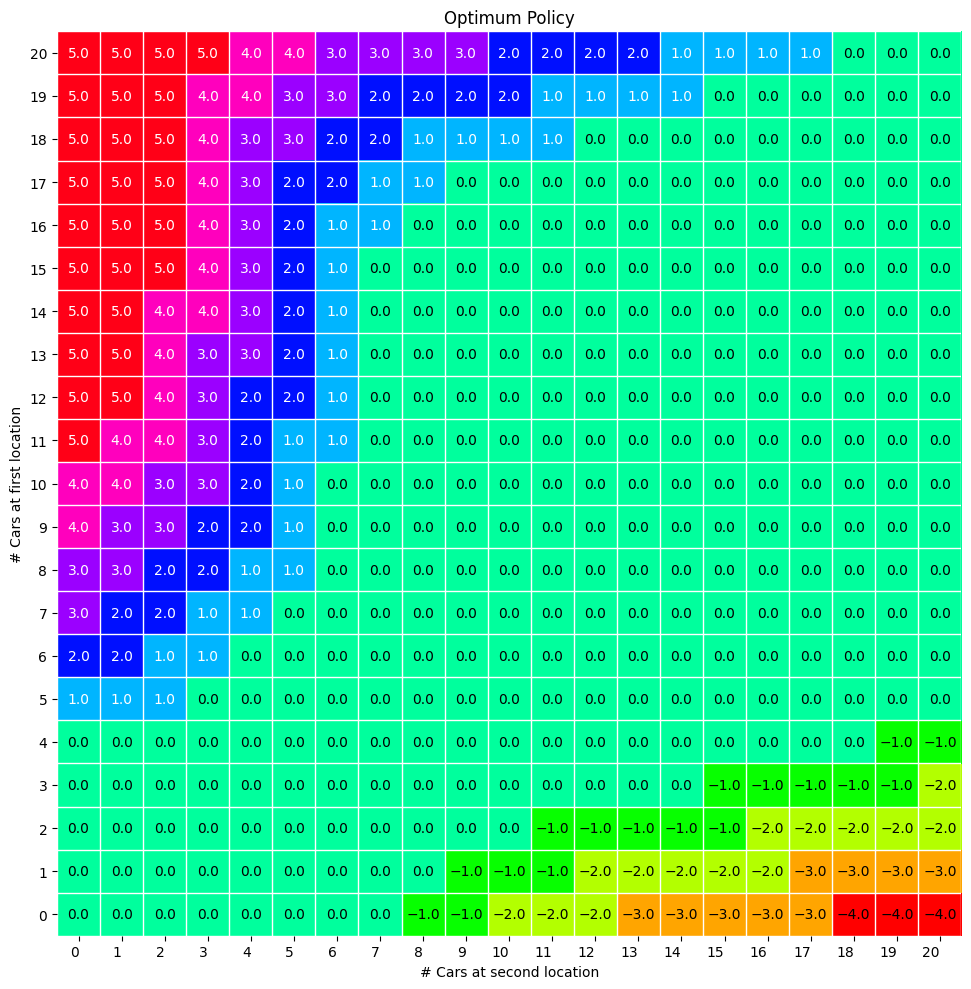

In [10]:
ma = np.zeros((n_A_max+1,n_B_max+1))
for (i,j),v in policy.items():    
    ma[i,j] = int(list(v)[0])
fig, ax = plt.subplots(1,1,figsize=(10,10))
im = heatmap(ma, np.arange(0, n_A_max+1), np.arange(0, n_B_max+1), ax=ax,
                   cmap="hsv",
                   origin="lower", 
               interpolation='none')
plt.title("Optimum Policy")
plt.xlabel("# Cars at second location")
plt.ylabel("# Cars at first location")
texts = annotate_heatmap(im, valfmt="{x}")
fig.tight_layout()
plt.show()

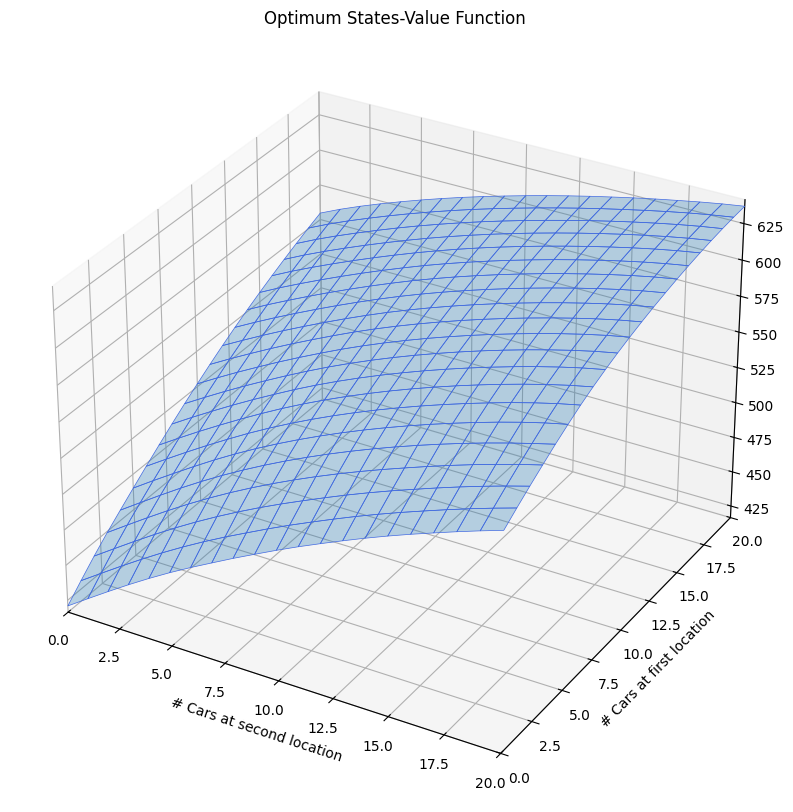

In [11]:
x = np.arange(0, n_B_max+1)
y = np.arange(0, n_A_max+1)
X, Y = np.meshgrid(x, y)
ma = np.zeros((n_A_max+1,n_B_max+1))
for (i,j), index in states_value["states"].items():
    ma[i,j] = states_value["values"][index]
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("Optimum States-Value Function")
plt.xlabel("# Cars at second location")
plt.ylabel("# Cars at first location")
ax.set_ylim((0, n_A_max))
ax.set_xlim((0, n_B_max))
cs = ax.plot_surface(X, Y, ma, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.3)
plt.show()